The objective of this notebook is to classify shoes images into one of three brands: Nike, Adidas and Converse. This is a simple classification task, and it is possible to achieve reasonably high precision (around 99% categorical accuracy) with relatively low computational cost.  

For this analysis, we will fit and compare the results of a naive classifier, a basic convolutional classifier, and a classifier that uses knowledge from a pre-trained model. This last model will then be fine-tuned to achieve maximum precision.

I tried to keep the code of this notebook as simple as possible in hopes of making it a great learning tool for people who are interested in transfer learning and fine-tuning. If you found it useful, please upvote and let me know that I helped :)

First, we open one of the images to check out its dimensions, and subsequently load our training, validation and testing datasets.

In [1]:
base_dir = '../input/nike-adidas-and-converse-imaged'
train_dir = base_dir + '/train'
test_dir = base_dir + '/test'
img_ex_dir = train_dir + '/adidas/100.jpg'

In [2]:
from PIL import Image
img = Image.open(img_ex_dir)
print('Image dimensions:', img.mode, img.size)

Image dimensions: RGB (240, 240)


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress tensorflow messages

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

def get_ds(ds, ds_dir, batch, image, color, v_split = None, subset = None):
    print('\n', ds, ':')
    return image_dataset_from_directory(ds_dir, batch_size = batch, image_size = image,
                                        color_mode = color, validation_split = v_split,
                                        subset = subset, seed = 0)

batch = 16
v_split = .2
train_ds = get_ds('Training', train_dir, batch, img.size, img.mode.lower(), v_split, 'training')
valid_ds = get_ds('Validation', train_dir, batch, img.size, img.mode.lower(), v_split, 'validation')
test_ds = get_ds('Testing', test_dir, batch, img.size, img.mode.lower())


 Training :
Found 711 files belonging to 3 classes.
Using 569 files for training.

 Validation :
Found 711 files belonging to 3 classes.
Using 142 files for validation.

 Testing :
Found 114 files belonging to 3 classes.


Then, we open 8 images from a training batch, to visualize what we are dealing with on this exercise, and to confirm how little we know about fashion. (Maybe you gals and guys know better, but I have to admit that, unless that high-contrast Nike logo is clearly standing out, I'm barely able to tell one brand from the other.)

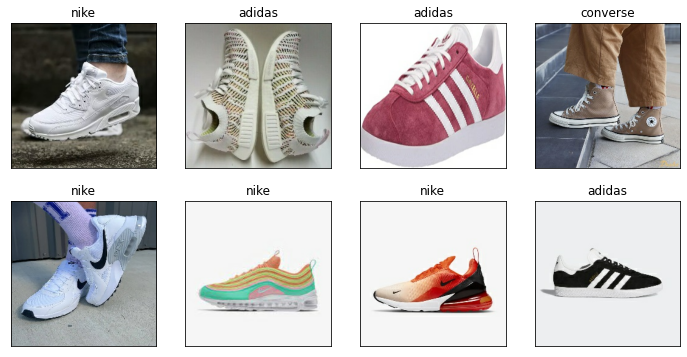

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize = (12, 6))
 
for images, labels in train_ds.take(1):
    for i in range(2):
        for j in range(4):
            index = i*4+j
            ax[i][j].imshow(images[index].numpy().astype("uint8"))
            ax[i][j].set_title(train_ds.class_names[labels[index]])
            ax[i][j].set(xticks=[], yticks=[])

Now we begin our neural network modelling. I assume this is what most of you want to read about, so from here onwards I'll leave all code cells visible.


Here, we allow asynchronous preparation and propagation of images - this is an important step to get the most of your CPU and GPU, and reduce the computational time required to fit and evaluate your models. We also combine the three datasets into a single object to make future coding easier and more readable.

In [6]:
from tensorflow.data import AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
valid_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
datasets = (train_ds, valid_ds, test_ds)

This next cell declares a function that returns a classifier. There is a lot going on here, so let's break it down:  
1. First, we initialize an empty base (more on that later), declare the inputs of our networks, and components that will be used by multiple models. The three components are: 
    1. data augmentation, to artificially increase the size of our training dataset
    1. scaling, to smooth out our gradients and facilitate the learning task
    1. a head, the final structure of all of our networks, which flattens data and combines every feature identified into probabilities for each of our three classes (Nike, Adidas and Converse).
    
    
2. Then, we choose our classifier. Again, there are three possible models:
    1. a naive classifier, which tries to guess the shoes brand based directly on the pixels of the image (this may seem silly, but it is a good method for setting up a 'baseline expectation' of the precision your model must have in order to be worth more than a random guess).
    1. a basic convolutional classifier, which first augments and scales the input and then passes it through three small convolutions (each with 32 filters).
    1. a classifier that uses knowledge from a pre-trained model. It first augments and scales the input, then incorporates every layer of the base of the Xception model, including its pre-trained weights on ImageNet, and finally condenses the resulting feature map through maximum pooling.


3. At last, we incorporate the head on our chosen classifier, and compile it using Adam as our optimizer. Adam is a replacement optimization algorithm that performs well in most situations (especially when handling sparse data).

In [7]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import Input, Sequential, layers, applications

def get_clf(clf_name):
    
    base_clf = None
    
    input_shape = (240, 240, 3)
    inputs = Input(shape = input_shape)
    
    data_augmentation = Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(.2),
        layers.RandomZoom(.2)
    ])
    
    scaling = Sequential([layers.Rescaling(scale = 1./255)])
    
    head = Sequential([layers.Flatten(), layers.Dense(units = 3, activation = 'softmax')])
    
    if clf_name == 'naive_clf':
        x = inputs
    
    elif clf_name == 'simple_clf':
        x = data_augmentation(inputs)
        x = scaling(x)
        x = layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(x)
        x = layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(x)
        x = layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(x)
  
    elif clf_name == 'Xception_clf':

        base_clf = applications.Xception(include_top = False, input_shape = input_shape)
        base_clf.trainable = False
        
        x = data_augmentation(inputs)
        x = scaling(x)
        x = base_clf(x, training = False)
        x = layers.MaxPooling2D()(x)
        
    else: assert(False)
    
    outputs = head(x)
    clf = Model(inputs, outputs, name = clf_name)
    
    clf.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['sparse_categorical_accuracy']
    )
    
    return base_clf, clf

Now, we declare a function that fits and evaluates a given model. It also prints the test accuracy and plots the resulting train/validation loss and accuracy over training epochs, so that we can interpret if our model has high bias, high variance, or if it is ready for production.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_result(ax, df, column_list, st = 10):
    data = df[column_list].loc[st:,:].melt(ignore_index=False).rename_axis('epoch').reset_index()
    sns.lineplot(ax = ax, data = data, x = 'epoch', y = 'value', hue = 'variable')

def fit_and_evaluate(clf_name, datasets, epochs):
    
    # fit model
    base_clf, clf = get_clf(clf_name)
    train_ds, valid_ds, test_ds = datasets
    results = clf.fit(train_ds, epochs = epochs, verbose = 0, validation_data = valid_ds)
    
    # print test results
    test_loss, test_accuracy = clf.evaluate(test_ds, verbose = 0)
    print('{} test accuracy: {:.0%}'.format(clf_name, test_accuracy))
    
    # plot fitting history
    fig, ax = plt.subplots(1, 2, figsize = (12, 3))
    res_df = pd.DataFrame(results.history)
    plot_result(ax[0], res_df, ['loss', 'val_loss'])
    plot_result(ax[1], res_df, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])
    
    return base_clf, clf

Here we start testing our three models, starting with our naive classifier. It will definitely have high bias and we can't even be sure that it will be any better than a random guess, but at least it sets the bar for us... anything with a lower accuracy than this is a terrible classifier.

naive_clf test accuracy: 56%


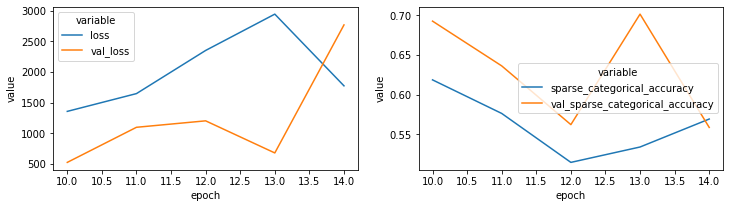

In [9]:
__, clf = fit_and_evaluate('naive_clf', datasets, epochs = 15)

After the naive classifier, we test our basic convolutional classifier and... surprise! It is just as bad as simply interpreting an image pixel by pixel. I guess this leaves us with an important message: that we should not expect our superficial work to have awesome results, that there is no free lunch, that we should either go big or go home, or simply that we should stop dwelling on empty motivational quotes and focus on the problem at hand.

simple_clf test accuracy: 40%


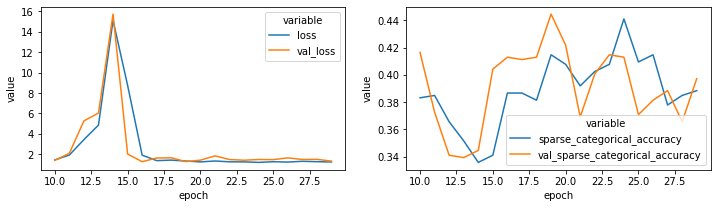

In [10]:
__, clf = fit_and_evaluate('simple_clf', datasets, epochs = 30)

Finally, we get to our last classifier. The one whose weights are mostly already tuned and frozen. The one that gets a headstart just by having all of the pre-trained feature extraction layers of an Xception. I just hope it performs better than our naive classifier, or this may get awkward.

83697664/83683744 [==============================] - 0s 0us/step
Xception_clf test accuracy: 94%


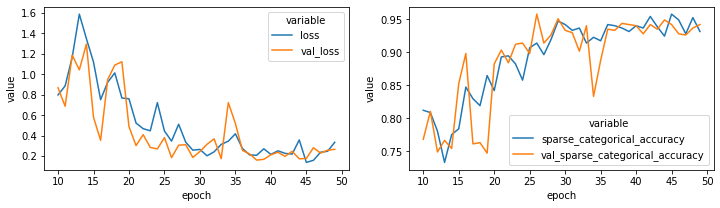

In [11]:
base_clf, clf = fit_and_evaluate('Xception_clf', datasets, epochs = 50)

Nice! A huge leap from our previous model. It already has around 90% accuracy, and there is still room for improvement.  

We now have a rough diamond, and the final stage of our analysis is to fine tune our entire model - including the Xception layers. For that to happen, in the next code cell we unfreeze the base layers, recompile our model using a very slow learning rate, and let it run for a few more epochs.

Fine-tuned Xception classifier test accuracy: 99%


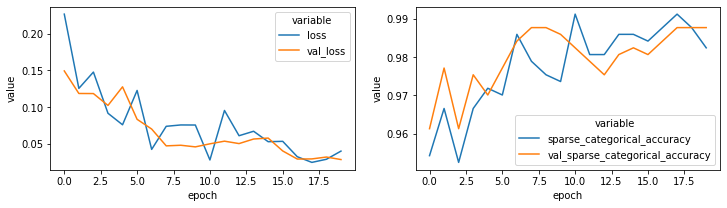

In [12]:
base_clf.trainable = True

clf.compile(
    optimizer = keras.optimizers.Adam(1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['sparse_categorical_accuracy']
)

results = clf.fit(train_ds, validation_data = valid_ds, epochs = 20, verbose = 0)
test_loss, test_accuracy = clf.evaluate(test_ds, verbose = 0)
print('Fine-tuned Xception classifier test accuracy: {:.0%}'.format(test_accuracy))

fig, ax = plt.subplots(1, 2, figsize = (12, 3))
res_df = pd.DataFrame(results.history)
plot_result(ax[0], res_df, ['loss', 'val_loss'], st = 0)
plot_result(ax[1], res_df, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'], st = 0)

Voilà... here we have a finely-tuned, neatly personalized deep learning model for the task of identifying a shoes brand. 

I hope you found this notebook insightful and eventually learned a thing or two from it. Good luck on your future projects!